<a href="https://colab.research.google.com/github/TonyCQin/medical-imaging-consistency/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from google.colab import drive


In [2]:
# --- 0. CONFIGURATION & PATHS (ADJUST THESE) ---
# The folder on your Google Drive containing chexpert.zip
GDRIVE_ROOT = '/content/drive/MyDrive/GT/Fall 2025/CS 7643/dataset/'

# File names (must match the files you uploaded)
ZIP_FILENAME = "chexpert.zip" # The large image archive file name

# Local Colab paths (where the files will be copied for fast I/O)
LOCAL_DATA_DIR = "/content/local_data_temp/"
LOCAL_ZIP_PATH = os.path.join(LOCAL_DATA_DIR, ZIP_FILENAME)

# Destination paths for the unpacked data
UNZIPPED_FOLDER_NAME = "chexpert"
FINAL_DATA_ROOT = "/content"

# Final paths for the CSV files inside the unpacked folder
CSV_TRAIN_PATH = os.path.join(FINAL_DATA_ROOT, "train.csv")
CSV_VALID_PATH = os.path.join(FINAL_DATA_ROOT, "valid.csv")


# --- 1. MOUNT GOOGLE DRIVE & COPY DATA TO LOCAL SSD ---
print("--- 1. Mounting Google Drive ---")
drive.mount('/content/drive')

print("\n--- 2. Copying ZIP file from Drive to fast local SSD ---")
!mkdir -p $LOCAL_DATA_DIR

# 1. Copy the main ZIP file only
DRIVE_ZIP_SOURCE = os.path.join(GDRIVE_ROOT, ZIP_FILENAME)
print(f"Copying {ZIP_FILENAME}...")
!cp "{DRIVE_ZIP_SOURCE}" "{LOCAL_ZIP_PATH}"

print("Copy complete. File is now on fast local storage.")

# --- 3. UNZIP ARCHIVE AND CLEAN UP ---
print("\n--- 3. Unzipping Archive ---")

# Unzip the large image archive to /content/. This creates the 'chexpert/' folder.
# NOTE: The destination is /content/ so the chexpert folder is created directly inside.
!unzip -q "{LOCAL_ZIP_PATH}" -d /content/

# Clean up the downloaded zip file and temporary directory
!rm -rf $LOCAL_DATA_DIR

print(f"Image data and CSVs ready in: {FINAL_DATA_ROOT}/")

--- 1. Mounting Google Drive ---
Mounted at /content/drive

--- 2. Copying ZIP file from Drive to fast local SSD ---
Copying chexpert.zip...
Copy complete. File is now on fast local storage.

--- 3. Unzipping Archive ---
Image data and CSVs ready in: /content/


In [3]:

# --- 4. DATA LOADING AND PATH CORRECTION ---
print("\n--- 4. Loading DataFrames and Correcting Paths ---")
REDUNDANT_PREFIX = "CheXpert-v1.0-small/"

def load_and_correct_paths(csv_path):
    """Loads a CSV, corrects image paths to be absolute on the Colab disk, and returns the DataFrame."""

    df = pd.read_csv(csv_path)

    # CRITICAL PATH CORRECTION:
    # The CSV paths are relative (e.g., 'train/patient...').
    # We must prepend the absolute root directory: /content/chexpert/
    df['Path'] = df['Path'].str.replace(REDUNDANT_PREFIX, '', regex=False)

    return df

# Load and correct the train and validation DataFrames
train_df = load_and_correct_paths("train.csv")
valid_df = load_and_correct_paths("valid.csv")

print(f"Train DataFrame loaded: {len(train_df)} rows")
print(f"Valid DataFrame loaded: {len(valid_df)} rows")




--- 4. Loading DataFrames and Correcting Paths ---
Train DataFrame loaded: 223414 rows
Valid DataFrame loaded: 234 rows



--- 5. Final Image Verification Test ---
✅ SUCCESS: Image read from path: valid/patient64541/study1/view1_frontal.jpg


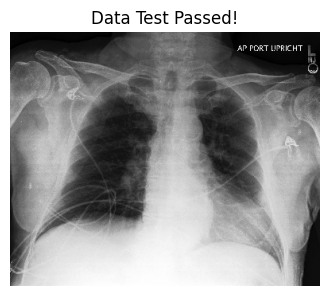


Training can begin using 'train_df' and 'valid_df'.


In [4]:

# --- 5. FINAL VERIFICATION (Image Test) ---
print("\n--- 5. Final Image Verification Test ---")

# Get the path of the first image in the validation DataFrame
test_image_path = valid_df['Path'].iloc[0]

try:
    # Read the image (using grayscale for X-rays)
    image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        print(f"✅ SUCCESS: Image read from path: {test_image_path}")

        # Display the image
        plt.figure(figsize=(4, 4))
        plt.imshow(image, cmap='gray')
        plt.title("Data Test Passed!")
        plt.axis('off')
        plt.show()
    else:
        print("❌ ERROR: cv2.imread returned None. File may be corrupted or path is slightly off.")
        # Check file details to see if it exists but is corrupted (e.g., 0 bytes)
        !ls -lh "{test_image_path}"

except FileNotFoundError:
    print(f"❌ CRITICAL ERROR: File Not Found at path: {test_image_path}")
    print(f"Path attempted: {test_image_path}")
    print("Ensure the zip file contents exactly match the CSV paths (e.g., 'chexpert/train/...' exists).")

print(f"\nTraining can begin using 'train_df' and 'valid_df'.")

In [5]:
!ls "/content"

drive  sample_data  train  train.csv  valid  valid.csv


Dataset setup

In [6]:
import torchvision.transforms as transforms
from torchvision.transforms import v2

# 1. Transforms for CNN-based Models (ResNet, EfficientNet, ConvNeXt)
# These models prefer smaller crop sizes and standard normalization.
cnn_transforms = transforms.Compose([
    transforms.Resize(256),         # Resize shortest side to 256
    transforms.CenterCrop(224),     # Crop to standard 224x224 input size
    transforms.ToTensor(),          # Convert image to a tensor (H, W, C -> C, H, W)
    transforms.Normalize(           # Standard ImageNet normalization (a good starting point)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Transforms for Vision Transformers (ViT, Swin)
# Transformers often benefit from a slightly larger input size (e.g., 384x384)
# and different augmentation strategies if trained from scratch.
vit_transforms = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(384),     # Larger input size for global attention
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [7]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

        # Select the 5 target labels for the CheXpert competition
        # baseline models benchmark against these five labels normally
        self.labels = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

        # Handle Uncertainty: Replace all -1 (uncertain) labels with 1 (positive) or 0 (negative)
        # Zero-imputation (-1 -> 0) is a common strategy
        self.df[self.labels] = self.df[self.labels].replace(-1, 0)
        self.df[self.labels] = self.df[self.labels].fillna(0) # Fill NaN (Not Applicable) with 0

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Load Image from Corrected Absolute Path
        img_path = self.df.iloc[idx]['Path']

        # Read the image in grayscale (0 is standard for X-ray)
        # cv2.IMREAD_GRAYSCALE or 0
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Convert grayscale image to 3 channels by stacking (required by ImageNet pretraining)
        image = np.stack([image] * 3, axis=-1)

        # Convert BGR (cv2 default) to RGB (not strictly necessary for grayscale, but safe practice)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Removed as we read grayscale

        # 2. Apply Transforms
        # Convert NumPy array to PIL Image before applying transforms
        from PIL import Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # 3. Load Labels
        label_vector = self.df.iloc[idx][self.labels].values.astype(np.float32)
        labels = torch.from_numpy(label_vector)

        return image, labels

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
NUM_WORKERS = 4 # Use multiple workers for fast data loading on Colab CPU

# -------------------------------------------------------------
# MODULAR SETUP 1: For ResNet / EfficientNet (using cnn_transforms)
# -------------------------------------------------------------
print("Setting up data for CNN model...")
# sample 2.2% of training data to simulate relatively sparse environment (5000 images)
train_df = train_df.sample(frac=0.022, random_state=42).reset_index(drop=True)
cnn_train_dataset = CheXpertDataset(train_df, transform=cnn_transforms)
cnn_valid_dataset = CheXpertDataset(valid_df, transform=cnn_transforms)

cnn_train_loader = DataLoader(
    cnn_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True # Speeds up transfer to GPU
)
cnn_valid_loader = DataLoader(
    cnn_valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("CNN DataLoaders ready.")

# -------------------------------------------------------------
# MODULAR SETUP 2: For ViT / Swin Transformer (using vit_transforms)
# -------------------------------------------------------------
print("\nSetting up data for Transformer model...")

vit_train_dataset = CheXpertDataset(train_df, transform=vit_transforms)
vit_valid_dataset = CheXpertDataset(valid_df, transform=vit_transforms)

vit_train_loader = DataLoader(
    vit_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
vit_valid_loader = DataLoader(
    vit_valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("ViT DataLoaders ready.")

Setting up data for CNN model...
CNN DataLoaders ready.

Setting up data for Transformer model...
ViT DataLoaders ready.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model Code

In [9]:
!pip install timm
import torch
import torch.nn as nn
import torchvision.models as models
import timm
print(timm.__version__)
available_coatnet_models = [m for m in timm.list_models() if 'coatnet' in m]
print("Available CoAtNet models:")
print(available_coatnet_models)

1.0.20
Available CoAtNet models:
['coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2_rw_384', 'coatnet_rmlp_3_rw_224', 'coatnet_rmlp_nano_rw_224']


In [10]:
num_classes = 5

## ResNet-50 (Standard PyTorch)
model_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# Replace the final fully connected layer (fc)
in_features_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features_resnet, num_classes)
print(f"ResNet-50 loaded with {num_classes} outputs.")

## EfficientNet-B0 (using timm)
# Use 'tf_efficientnet_b0' for common variant
model_efficientnet = timm.create_model('tf_efficientnet_b0', pretrained=True, num_classes=num_classes)
print(f"EfficientNet-B0 loaded with {num_classes} outputs.")

## ConvNeXt-Tiny (using timm)
model_convnext = timm.create_model('convnext_tiny', pretrained=True, num_classes=num_classes)
print(f"ConvNeXt-Tiny loaded with {num_classes} outputs.")

# ViT (Vision Transformer) - 'vit_base_patch16_224' is a standard starting point
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
print(f"ViT-Base loaded with {num_classes} outputs.")

# Swin Transformer (Swin-T) - Note: Default timm weights are often ImageNet-1k/22k
model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
print(f"Swin-Tiny loaded with {num_classes} outputs.")

# DeiT (Data-efficient Image Transformer) - Uses distillation for better performance
model_deit = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes)
print(f"DeiT-Base loaded with {num_classes} outputs.")

# CoAtNet (Hybrid CNN-Transformer)
model_coatnet = timm.create_model('coatnet_0_rw_224', pretrained=True, num_classes=num_classes)
print(f"CoAtNet-0 loaded with {num_classes} outputs.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 41.3MB/s]


ResNet-50 loaded with 5 outputs.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet-B0 loaded with 5 outputs.


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt-Tiny loaded with 5 outputs.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT-Base loaded with 5 outputs.


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin-Tiny loaded with 5 outputs.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

DeiT-Base loaded with 5 outputs.


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

CoAtNet-0 loaded with 5 outputs.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm.auto import tqdm

def run_experiment(model, train_loader, valid_loader, model_name, num_epochs=20, learning_rate=1e-4, checkpoint_dir='drive/MyDrive/checkpoints'):
    """
    Trains and validates a PyTorch model for multi-label classification.

    Args:
        model (nn.Module): The model architecture (e.g., model_resnet, model_vit).
        train_loader (DataLoader): DataLoader for the training set.
        valid_loader (DataLoader): DataLoader for the validation set.
        model_name (str): Unique name for the current model (e.g., 'ResNet50', 'Swin_Tiny').
        num_epochs (int): Number of epochs to train.
        learning_rate (float): Initial learning rate for the optimizer.
        checkpoint_dir (str): Persistent path to save best model weights.
    """
    # 1. Setup Device and Components
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # BCEWithLogitsLoss is standard for multi-label classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Scheduler reduces LR when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    best_val_auc = 0.0

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"\n--- Starting Training: {model_name} on {device} ---")
    start_time = time.time()
    epoch_bar = tqdm(range(num_epochs), desc=f"Experiment: {model_name}")

    for epoch in epoch_bar:
        epoch_start_time = time.time()

        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            train_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader.dataset)

        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0
        all_targets = []
        all_predictions = []

        valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1} Valid", leave=False)

        with torch.no_grad():
            for inputs, labels in valid_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                probabilities = torch.sigmoid(outputs).cpu().numpy()
                all_targets.append(labels.cpu().numpy())
                all_predictions.append(probabilities)

        val_loss = running_val_loss / len(valid_loader.dataset)

        targets_np = np.concatenate(all_targets)
        predictions_np = np.concatenate(all_predictions)

        # Calculate Mean AUC
        try:
            val_auc = roc_auc_score(targets_np, predictions_np, average='macro')
        except ValueError:
            val_auc = 0.0 # Handle case where AUC cannot be computed (e.g., one class missing)

        # Update Learning Rate Scheduler
        scheduler.step(val_loss)

        epoch_bar.set_postfix_str(f"Loss: {train_loss:.4f}, Val AUC: {val_auc:.4f}")

        # --- Reporting and Checkpointing ---
        print(f"Epoch {epoch+1:02d}/{num_epochs} ({time.time() - epoch_start_time:.1f}s) | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Mean AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            # Save weights to the unique checkpoint path
            checkpoint_file = os.path.join(checkpoint_dir, f'{model_name}_best.pth')
            torch.save(model.state_dict(), checkpoint_file)
            print(f"       ✅ Model checkpoint saved! New Best AUC: {best_val_auc:.4f}")

    total_time = (time.time() - start_time) / 60
    print(f"\nTraining for {model_name} complete. Total time: {total_time:.2f} minutes.")
    print(f"Final Best Validation Mean AUC: {best_val_auc:.4f}")

    return best_val_auc

In [ ]:
# # Assuming you have loaded your models and data loaders:
# # model_resnet, model_vit, cnn_train_loader, vit_train_loader, etc.

best_auc_resnet = run_experiment(
    model=model_resnet,
    train_loader=cnn_train_loader,
    valid_loader=cnn_valid_loader,
    model_name='ResNet50',
    num_epochs=30,
    learning_rate=5e-5 # Lower LR often better for fine-tuning
)

# best_auc_efficientnet = run_experiment(
#     model=model_efficientnet,
#     train_loader=cnn_train_loader,
#     valid_loader=cnn_valid_loader,
#     model_name='EfficientNet-B0',
#     num_epochs=30,
#     learning_rate=5e-5 # Lower LR often better for fine-tuning
# )

# best_auc_convnext = run_experiment(
#     model=model_convnext,
#     train_loader=cnn_train_loader,
#     valid_loader=cnn_valid_loader,
#     model_name='convnext_tiny',
#     num_epochs=30,
#     learning_rate=5e-5 # Lower LR often better for fine-tuning
# )

# best_auc_coatnext = run_experiment(
#     model=model_coatnet,
#     train_loader=cnn_train_loader,
#     valid_loader=cnn_valid_loader,
#     model_name='CoAtNet-0',
#     num_epochs=30,
#     learning_rate=5e-5 # Lower LR often better for fine-tuning
# )

# # --- Experiment 2: ViT-Base (using ViT loaders with larger input) ---
# best_auc_vit = run_experiment(
#     model=model_vit,
#     train_loader=vit_train_loader,
#     valid_loader=vit_valid_loader,
#     model_name='ViT_Base_384',
#     num_epochs=30,
#     learning_rate=2e-5 # Even lower LR for larger models
# )

# best_auc_swin = run_experiment(
#     model=model_swin,
#     train_loader=vit_train_loader,
#     valid_loader=vit_valid_loader,
#     model_name='swin_tiny_patch4_window7_224',
#     num_epochs=30,
#     learning_rate=2e-5 # Even lower LR for larger models
# )

# best_auc_deit = run_experiment(
#     model=model_deit,
#     train_loader=vit_train_loader,
#     valid_loader=vit_valid_loader,
#     model_name='deit_base_patch16_224',
#     num_epochs=30,
#     learning_rate=2e-5 # Even lower LR for larger models
# )


--- Starting Training: ResNet50 on cpu ---


Experiment: ResNet50:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1 Train:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 1 Valid:   0%|          | 0/4 [00:00<?, ?it/s]